# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

<a target="_blank" href="https://colab.research.google.com/github/arindamchoudhury/ml-projects/blob/main/MNIST_Handwritten_Digits.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [27]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm 

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [16]:
# Define transforms
## YOUR CODE HERE ##
# https://nextjournal.com/gkoehler/pytorch-mnist Normalize params 
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])
# Create training set and define training dataloader
## YOUR CODE HERE ##
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [50000, 10000])

# Create test set and define test dataloader
## YOUR CODE HERE ##
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The values 0.1307 and 0.3081 used for the Normalize() transformation are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [17]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


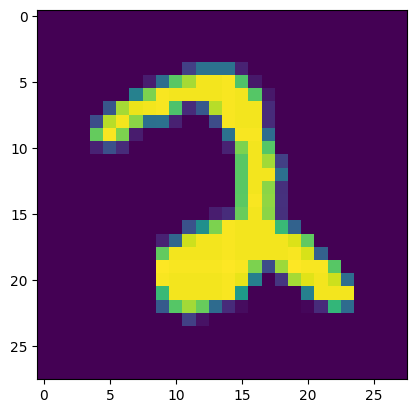

4


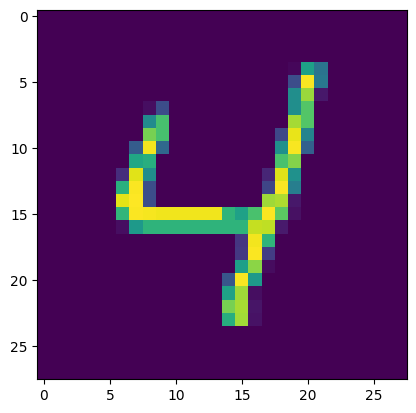

9


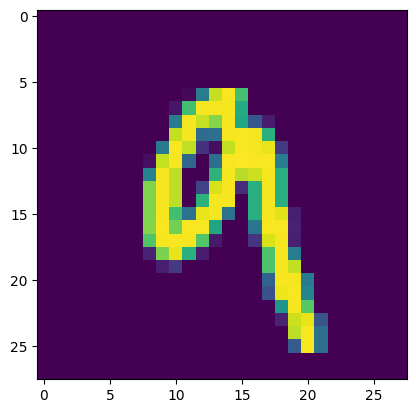

2


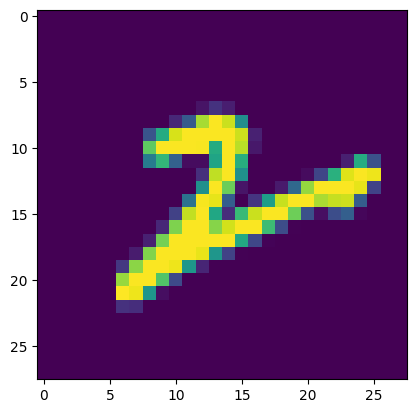

0


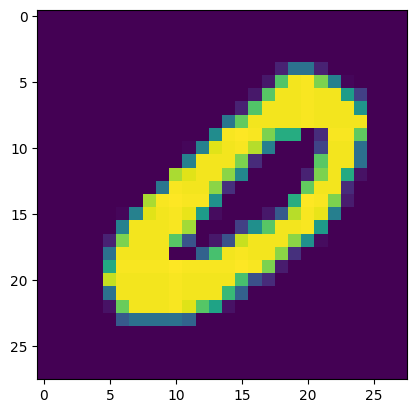

In [12]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [30]:
## YOUR CODE HERE ##
# base of the LeNet5 collected from https://github.com/rgkannan676/MNIST-Handwritten-Digit-Recognition/blob/main/OptmizerSelection.py
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.bn1 = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.bn2 = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = self.relu(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = out.view(-1,16*5*5)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = self.fc3(out)
        return out
    
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [46]:
## YOUR CODE HERE ##
optimizer =  optim.Adam(net.parameters(), lr=0.003, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [47]:
def accuracy(logits, labels):
    _, yhat = torch.max(logits.data, dim=1)
    equals = yhat == labels
    return torch.mean(equals.type(torch.FloatTensor))

In [48]:
## YOUR CODE HERE ##
# collected from https://www.coursera.org/projects/pneumonia-classification-using-pytorch
class ModelTrainer():
    def __init__(self, criterion = None, optimizer = None):        
        self.criterion = criterion
        self.optimizer = optimizer
  
    def train_batch_loop(self, model, trainloader):        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):            
            images = images.to(device)
            labels = labels.to(device)
            
            self.optimizer.zero_grad()
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):                
            images = images.to(device)
            labels = labels.to(device)
             
            logits = model(images)
            loss = self.criterion(logits, labels)
              
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs, filename):        
        valid_min_loss = np.Inf
        train_loss_history = list()
        valid_loss_history = list()
        
        for i in range(epochs):            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            train_loss_history.append(avg_train_loss)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)
            valid_loss_history.append(avg_valid_loss)
            
            if avg_valid_loss < valid_min_loss:
                print(f"validation loss decreased {valid_min_loss} --> {avg_valid_loss}")
                torch.save(model.state_dict(), filename)
                valid_min_loss = avg_valid_loss

                
            print(f"Epoch : {i+1} Train Loss : {avg_train_loss:.6f} Train Acc : {avg_train_acc:.6f}")
            print(f"Epoch : {i+1} Valid Loss : {avg_valid_loss:.6f} Valid Acc : {avg_valid_acc:.6f} Min Loss : {valid_min_loss:.6f}")
        
        return train_loss_history, valid_loss_history

In [49]:
trainer = ModelTrainer(criterion, optimizer)
train_loss_history, valid_loss_history = trainer.fit(model=net, trainloader=train_loader, validloader=valid_loader, epochs=20, filename="leNet.pt")

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased inf --> 0.6392822778149015
Epoch : 1 Train Loss : 0.535914 Train Acc : 0.960158
Epoch : 1 Valid Loss : 0.639282 Valid Acc : 0.945860 Min Loss : 0.639282


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.6392822778149015 --> 0.5311575097263239
Epoch : 2 Train Loss : 0.510121 Train Acc : 0.960818
Epoch : 2 Valid Loss : 0.531158 Valid Acc : 0.965963 Min Loss : 0.531158


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.516640 Train Acc : 0.958919
Epoch : 3 Valid Loss : 0.542673 Valid Acc : 0.954419 Min Loss : 0.531158


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.5311575097263239 --> 0.5159510647415355
Epoch : 4 Train Loss : 0.513458 Train Acc : 0.960378
Epoch : 4 Valid Loss : 0.515951 Valid Acc : 0.946258 Min Loss : 0.515951


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.513409 Train Acc : 0.959819
Epoch : 5 Valid Loss : 0.526953 Valid Acc : 0.963774 Min Loss : 0.515951


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.5159510647415355 --> 0.462746020145477
Epoch : 6 Train Loss : 0.510957 Train Acc : 0.960498
Epoch : 6 Valid Loss : 0.462746 Valid Acc : 0.961186 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.509872 Train Acc : 0.960298
Epoch : 7 Valid Loss : 0.509825 Valid Acc : 0.965167 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.513687 Train Acc : 0.959479
Epoch : 8 Valid Loss : 0.568759 Valid Acc : 0.953722 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.518202 Train Acc : 0.958460
Epoch : 9 Valid Loss : 0.678574 Valid Acc : 0.908937 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.516829 Train Acc : 0.958080
Epoch : 10 Valid Loss : 0.505625 Valid Acc : 0.961087 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.518933 Train Acc : 0.957661
Epoch : 11 Valid Loss : 0.545300 Valid Acc : 0.950736 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.517800 Train Acc : 0.958460
Epoch : 12 Valid Loss : 0.523853 Valid Acc : 0.947353 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.518403 Train Acc : 0.957241
Epoch : 13 Valid Loss : 0.776940 Valid Acc : 0.867436 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.521144 Train Acc : 0.956821
Epoch : 14 Valid Loss : 0.539526 Valid Acc : 0.951135 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.518190 Train Acc : 0.957541
Epoch : 15 Valid Loss : 0.517496 Valid Acc : 0.961584 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.514502 Train Acc : 0.958520
Epoch : 16 Valid Loss : 0.634449 Valid Acc : 0.950637 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.514935 Train Acc : 0.959259
Epoch : 17 Valid Loss : 0.513714 Valid Acc : 0.955016 Min Loss : 0.462746


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.462746020145477 --> 0.44460832939785755
Epoch : 18 Train Loss : 0.514472 Train Acc : 0.958820
Epoch : 18 Valid Loss : 0.444608 Valid Acc : 0.960291 Min Loss : 0.444608


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.511888 Train Acc : 0.959699
Epoch : 19 Valid Loss : 0.528356 Valid Acc : 0.943372 Min Loss : 0.444608


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.514027 Train Acc : 0.959419
Epoch : 20 Valid Loss : 0.591192 Valid Acc : 0.941083 Min Loss : 0.444608


Plot the training loss (and validation loss/accuracy, if recorded).

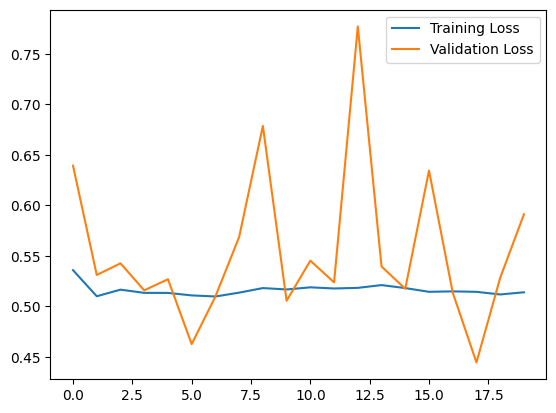

In [50]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [51]:
## YOUR CODE HERE ##
test_net = LeNet5()
test_net.to(device)
test_net.load_state_dict(torch.load('leNet.pt'))
test_net.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(test_net, test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.43659309103230765
Test Acc : 0.9619824886322021


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [52]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), "LeNetFinal.pt")